In [ ]:
import numpy as np
import pyfastchem as pyFC
import matplotlib.pyplot as plt

In [ ]:
# Create a FastChem object
pyFC_obj = pyFC.FastChem(
    '/home/sam/Documents/PhD/CRIRES_data_reduction/fastchem/input/element_abundances/asplund_2020.dat', 
    '/home/sam/Documents/PhD/CRIRES_data_reduction/fastchem/input/logK/logK.dat', 
    '/home/sam/Documents/PhD/CRIRES_data_reduction/fastchem/input/logK/logK_condensates.dat', 
    1
)

In [ ]:
input_data = pyFC.FastChemInput()
output_data = pyFC.FastChemOutput()

#we read in a p-T structure for a brown dwarf
data = np.loadtxt(
    '/home/sam/Documents/PhD/CRIRES_data_reduction/fastchem/input/example_p_t_structures/Brown_dwarf_Sonora.dat'
    )

#and extract temperature and pressure values
temperature = data[:,1]
pressure = data[:,0]

from scipy.interpolate import interp1d
#new_pressure = np.logspace(-3,2,50)
#new_pressure = np.logspace(3,-6,100)
new_pressure = np.logspace(3,-6,50)
temperature = interp1d(np.log10(pressure), temperature, fill_value='extrapolate')(np.log10(new_pressure))
#temperature = np.interp(np.log10(new_pressure), np.log10(pressure)[::-1], temperature[::-1])
pressure = new_pressure

input_data.temperature = temperature
input_data.pressure = pressure

#use equilibrium condensation
input_data.equilibrium_condensation = True

#this would turn on the rainout condensation approach
#input_data.rainout_condensation = True

In [ ]:
#for this calculation, we need to change some of FastChem's internal parameters
pyFC_obj.setParameter('accuracyChem', 1e-4)
#pyFC_obj.setParameter('nbIterationsChem', 1)

In [ ]:
import time

time_A = time.time()
#run FastChem on the entire p-T structure
fastchem_flag = pyFC_obj.calcDensities(input_data, output_data)
print('{:.2f} s'.format(time.time()-time_A))

#convergence summary report
print("FastChem reports:")
print("  -", pyFC.FASTCHEM_MSG[fastchem_flag])

if np.amin(output_data.element_conserved[:]) == 1:
  print("  - element conservation: ok")
else:
  print("  - element conservation: fail")

print(fastchem_flag)
print(pyFC.FASTCHEM_SUCCESS)
print(pyFC.FASTCHEM_NO_CONVERGENCE)
print(pyFC.FASTCHEM_IS_BUSY)

number_densities = np.array(output_data.number_densities)

In [ ]:
dir(pyFC_obj)

In [ ]:
species_to_plot = ['Fe1H1', 'Fe', 'Fe1S1', 'C1O1', 'C1O2', 'C1H4', 'F1H1', 'Cl1H1', 'H3N1', 'H2S1']
labels_to_plot  = ['FeH', 'Fe', 'FeS', 'CO', 'CO2', 'CH4', 'HF', 'HCl', 'NH3', 'H2S']

#species_to_plot = ['K', 'Na', 'Ti', 'Fe', 'Ca', 'Al', 'Mg', 'He']
#labels_to_plot  = ['K', 'Na', 'Ti', 'Fe', 'Ca', 'Al', 'Mg', 'He']

from astropy import constants as const
gas_number_density = pressure*1e6 / (const.k_B.cgs.value * temperature)

fig, ax = plt.subplots(figsize=(6,6))

for species_i, label_i in zip(species_to_plot, labels_to_plot):
    nd_i = number_densities[:,pyFC_obj.getGasSpeciesIndex(species_i)]
    VMR_i = nd_i/gas_number_density

    ax.plot(VMR_i, pressure, label=label_i)

ax_PT = ax.twiny()
ax_PT.plot(temperature, pressure, c='k', ls='--')
ax_PT.set(xlim=(0,3500))

ax.legend(ncols=2)
ax.set(yscale='log', xscale='log', ylim=(1e-6,1e3), xlim=(1e-12,1e-2))
ax.set(xlim=(1e-12,1e0))
ax.invert_yaxis()
plt.show()

In [ ]:
pyFC_obj.getGasSpeciesWeight(pyFC_obj.getGasSpeciesIndex('C1H4'))

masses = np.array([
    pyFC_obj.getGasSpeciesWeight(i) for i in range(number_densities.shape[1])
])

In [ ]:
number_densities_quenched = number_densities.copy()

mask_P_quench = (np.log10(pressure) <= 0.5)

for species_i in ['C1H4', 'C1O1', 'H2O1', 'C1H1O1', 'C1H2O1', 'C1H3']:
    idx = pyFC_obj.getGasSpeciesIndex(species_i)

    number_densities_quenched[mask_P_quench,idx] = number_densities[~mask_P_quench,idx][-1]

    #print(number_densities_quenched[:,idx])

print(
    np.sum(masses[None,:]*number_densities_quenched/gas_number_density[:,None], axis=1)
)

print(
    np.sum(masses[None,:]*number_densities/gas_number_density[:,None], axis=1)
)

## Retrieval test

In [1]:
import numpy as np
from retrieval_base.chemistry import FastChemistry

fastchem_path = '/home/sam/Documents/PhD/CRIRES_data_reduction/fastchem/input'

#we read in a p-T structure for a brown dwarf
data = np.loadtxt(
    '/home/sam/Documents/PhD/CRIRES_data_reduction/fastchem/input/example_p_t_structures/Brown_dwarf_Sonora.dat'
    )

pressure = np.logspace(-6,2,50)
from scipy.interpolate import interp1d
#temperature = interp1d(
#    np.log10(data[:,0][::-1]), data[:,1][::-1], 
#    kind='linear', fill_value='extrapolate', 
#    )(np.log10(pressure))
temperature = np.interp(
    np.log10(pressure), np.log10(data[:,0][::-1]), data[:,1][::-1], 
    )
temperature -= 159.72

print(temperature)

[ 100.          100.          100.          100.          100.
  100.          100.          100.          100.          100.
  100.          100.          100.          100.          100.71029959
  104.74832862  110.26417597  117.00636497  124.04196689  131.45271905
  139.62824481  148.91955095  159.00628637  169.75801405  181.10105877
  193.53600719  207.48798724  223.06034314  241.2069057   262.44560628
  287.51514743  317.81967258  353.75440592  395.84191038  444.81266032
  499.64344012  560.83619235  629.98123939  710.03841348  806.65991803
  917.97351181 1038.64141756 1149.40200739 1253.49115404 1357.59216402
 1475.57587763 1627.78030803 1811.81626113 2008.78404134 2218.55120249]


In [2]:
Chem = FastChemistry(
    line_species=[
        'CH4_hargreaves_main_iso', 
        'H2O_pokazatel_main_iso', 
        'CO_main_iso', 

        'CO_36', 
        
        'NH3_coles_main_iso', 
        'HCN_main_iso', 
        
        'FeH_main_iso', 
        'Fe', 

        'H2S_ExoMol_main_iso', 

        'K', 
        'Na', 
        ], 
    pressure=pressure, 
    abundance_file=f'{fastchem_path}/element_abundances/asplund_2020.dat', 
    gas_data_file=f'{fastchem_path}/logK/logK.dat', 
    cond_data_file=f'{fastchem_path}/logK/logK_condensates.dat', 
    verbose_level=1, 
    #use_rainout_cond=False, 
)

params = {
    'C/O': 0.6, 
    'Fe/H': 0.0, 
    #'P_quench': 10**0.5, 
    'P_quench': 10**(1.5), 
    #'P_quench': 10**(-8), 
    'C13_12_ratio': 1/10, 
}
mf = Chem(params, temperature)


FastChem initialisation summary:
  number of species: 709    elements: 28    molecules: 495    condensates: 186



In [7]:
print(
    np.vstack((Chem.output.nb_iterations, Chem.output.nb_chemistry_iterations, Chem.output.nb_cond_iterations)).T
)

[[   4   36   34]
 [   2   32   68]
 [   2   27  137]
 [   2   21   76]
 [   2   17   39]
 [   1   13   41]
 [   1   15   42]
 [   1   15   46]
 [   1   14   52]
 [  20  688  115]
 [   1  115   82]
 [   2 2005  125]
 [   2   13   59]
 [   2   12  330]
 [   1   10  234]
 [   1    9  155]
 [   1    9  141]
 [   1    9   91]
 [   1    8   65]
 [   1    8   43]
 [   1    8   52]
 [   1    8   60]
 [   1    8   58]
 [  24   31   75]
 [  11   18   61]
 [   1    8   32]
 [   1    8   32]
 [   1    8   32]
 [   1    8   35]
 [   1    8   38]
 [   1    8   40]
 [   1    7   40]
 [   1    7   42]
 [   1    5   42]
 [   1    5   46]
 [   1    5   48]
 [   1    5   46]
 [   1    5   38]
 [   1    5   25]
 [   1    5   25]
 [   0    3    0]
 [   0    3    0]
 [   0    3    0]
 [   0    3    0]
 [   0    3    0]
 [   0    3    0]
 [   0    3    0]
 [   0    3    0]
 [   0    3    0]
 [   0    3    0]]


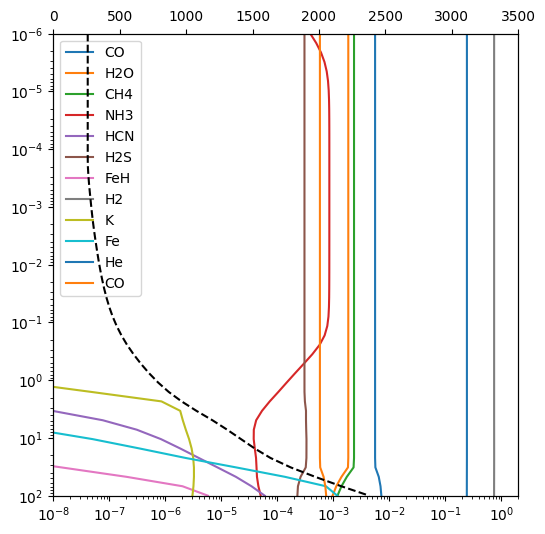

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))

for species_i, mf_i in mf.items():
    if species_i == 'MMW':
        continue
    ax.plot(mf_i, pressure, label=species_i.split('_')[0])

ax_PT = ax.twiny()
ax_PT.plot(temperature, pressure, c='k', ls='--')
ax_PT.set(xlim=(0,3500))

ax.legend()
ax.set(yscale='log', ylim=(1e-6,1e2), xscale='log', xlim=(1e-8,2))
ax.invert_yaxis()
plt.show()

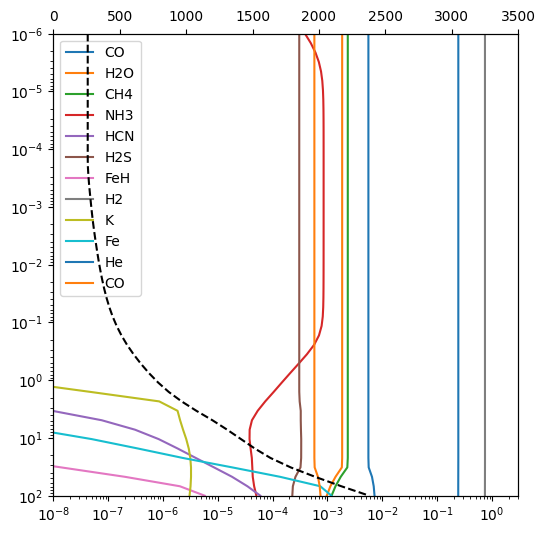

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))

for species_i, mf_i in mf.items():
    if species_i == 'MMW':
        continue
    ax.plot(mf_i, pressure, label=species_i.split('_')[0])

ax_PT = ax.twiny()
ax_PT.plot(temperature, pressure, c='k', ls='--')
ax_PT.set(xlim=(0,3500))

ax.legend()
ax.set(yscale='log', ylim=(1e-6,1e2), xscale='log', xlim=(1e-8,3))
ax.invert_yaxis()
plt.show()

In [ ]:
print(Chem.solar_abundances[Chem.fastchem.getElementIndex('Fe')])

In [ ]:
print(Chem.log_FeH_solar)

In [ ]:
10**(-0.8+Chem.log_FeH_solar) / 10**Chem.log_FeH_solar

In [ ]:
10**(+0.8)